# SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing (2018)

출처: [https://arxiv.org/pdf/1808.06226.pdf](https://arxiv.org/pdf/1808.06226.pdf)

## Abstract

이 논문에서는  Neural Machine Translation (NMT)을 포함한 신경망 기반 텍스트 처리를 위해 설계된 언어 독립적인 subword tokenizer 및 detokenizer인 SentencePiece에 대해 설명합니다.

기존의 subword segmentation 도구는 입력이 단어 시퀀스로 사전 토큰화되었다고 가정하지만, SentencePiece는 기존의 문장에서 직접 subword 모델을 훈련할 수 있으므로 순수한 end-to-end, 언어 독립적 시스템을 만들 수 있습니다.

여기선 영어-일본어 기계 번역에 대한 NMT의 검증 실험을 수행하고 기존 문장에서 직접 subword training을 한 것과 비슷한 정확도를 달성할 수 있음을 발견했습니다. 또한, 다양한 구성으로 subword training 및 segmentation의 성능을 비교합니다. SentencePiece는 [https://github.com/google/sentencepiece](https://github.com/google/sentencepiece)에서의 Apache 2 라이선스로 이용할 수 있습니다.



## 1 Introduction

Deep neural network는 자연어 처리에 큰 영향을 미치고 있습니다.

이러한 도구들은 주로 단어가 띄어쓰기로 segmentation되는 유럽 언어용으로 설계되었습니다. 중국어, 한국어, 일본어와 같은 띄어쓰기 만으로 segmentation이 되지 않는 언어에 대한 NMT 시스템을 훈련하려면 단어 segmentator를 따로 실행해야 합니다.

이러한 언어 의존적인 processing은 언어마다 pre 혹은 post processor 아키텍처를 신중하게 다뤄야 합니다. 하지만, 내부의 deep neural architecture는 언어 독립적이기 때문에 다국어 NMT 모델을 훈련시키기 어렵게 만듭니다.

NMT 접근 방식이 표준화되고 언어에 구애받지 않는 아키텍처로 발전함에 따라 NLP 커뮤니티가 Neural Network 기반 NLP에 쉽게 통합할 수 있는 간단하고 효율적이며 재현 가능하며 언어 독립적인 전처리 및 후처리 processor를 개발하는 것이 더욱 중요해지고 있습니다. 이 논문에서는 Neural model 훈련에 앞서 어휘의 크기가 미리 결정되는 Neural Network 기반 text generation 시스템을 위한 단순하고 언어 독립적인 텍스트 tokenizer 및 detokenizer인 SentencePiece에 대해 설명합니다.

SentencePiece는 원래의 문장에서 직접 훈련하는 것을 확장하여 Byte Pair Encoding (BPE) 및 unigram language model의 두 가지 subword segmentation 알고리즘을 구현합니다.

SentencePiece를 사용하면 언어별 processing에 의존하지 않는 완전한 end-to-end 시스템을 구축할 수 있습니다.

## 2 System Overview

SentencePiece는 **Normalizer, Trainer, Encoder 및 Decoder**의 네 가지로 구성됩니다. **Normalizer**는 의미적으로 동일한 유니코드 문자를 표준 형식으로 정규화하는 모듈입니다. **Trainer**는 정규화된 corpus에서 하위 단어 세분화 모델을 훈련합니다. Trainer의 매개변수로 subword model의 유형을 지정합니다. **Encoder**는 내부적으로 Normalizer를 실행하여 입력 텍스트를 정규화하고 Trainer가 훈련한 하위 단어 모델을 사용하여 하위 단어 시퀀스로 토큰화합니다. **Decoder**는 subword 시퀀스를 정규화된 텍스트로 변환합니다.



## 3 Library Design

이 섹션에선 command line과 code snippet을 통해 SentencePiece의 설계 및 구현 디테일을 설명합니다.

### 3.1 Lossless Tokenization

다음의 원래 및 토큰화된 문장은 언어에 종속적인 전처리의 예입니다.

- **Rawtext:** Hello world. 
- **Tokenized:** [Hello][world][.]

여기서 볼 수 있는 것은 기존의 텍스트와 토큰화된 시퀀스가 원래 상태로 바꿀 수 없다는 것입니다. "world"와 "." 사이에 공백이 없다는 정보는 토큰화된 시퀀스에 유지되지 않습니다. 토큰화된 시퀀스에서 원래의 입력을 복원하는 프로세스인 detokenization은 이러한 되돌릴 수 없는 작업으로 인해 언어에 종속적이어야 합니다. 예를 들어, detokenizer는 대부분의 유럽 언어에서 기본 토큰 사이에 공백을 넣지만, 일본어와 중국어에서는 공백이 필요하지 않습니다.

- **Rawtext:** [こんにちは世界。] (Hello world.) 
- **Tokenized:** [こんにちは][世界][。]

이러한 언어별 처리는 일반적으로 많은 비용이 드는 직접 만든 규칙에서 시행되었습니다. SentencePiece는 디코더를 인코더의 역연산으로 구현합니다. 그 예는 아래와 같습니다.

$$Decode(Encode(Normalize(text))) = Normalize(text).$$

표준화된 텍스트를 복구하기 위한 모든 정보가 인코더의 출력에 보존되는 이 디자인을  **lossless tokenization**라고 합니다. **lossless tokenization**의 기본 아이디어는 입력 텍스트를 유니코드 문자 시퀀스로 취급하는 것입니다. 공백도 일반 기호로 처리됩니다. 명확하게 하기 위해 SentencePiece는 먼저 메타 기호 \_(U+2581)로 공백을 이스케이프 처리하고 입력을 임의의 하위 단어 시퀀스로 토큰화합니다. 예를 들면 다음과 같습니다.

- **Rawtext:** Hello_world. 
- **Tokenized:** [Hello][_wor][ld][.]

토큰화된 텍스트에서 공백이 유지되므로 다음 Python 코드로 모호성 없이 토큰을 detokenize할 수 있습니다.

```python
detok = "".join(tokens).replace("_", " ")
```

반면에 [subword-nmt2](https://github.com/rsennrich/subword-nmt)는 subword 단위에 대해 다른 표현을 채택한다는 점에 유의해야 합니다. 단어가 subword로 분할되는 방식에 초점을 맞추고 @@를 단어 내 boundary marker로 사용합니다.

- **Tokenized:** [Hello][wor][@@ld][@@.]

이 표현 방식은 공백 처리에 모호함이 남아 있기 때문에 항상 lossless  tokenization을 수행할 수 있는 것은 아닙니다. 더 구체적으로 말하면 이 표현으로 연속적인 공백을 인코딩할 수 없습니다.

### 3.2 Efficient subword training and segmentation

SentencePiece는 $O(Nlog(N))$ 알고리즘을 채택합니다.

- BPE segmentation은 $O(N^2)$
- unigram language model은 input 데이터의 크기와 선형관계

### 3.6 Library API for on-the-fly processing

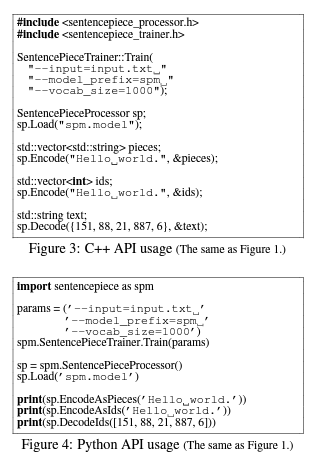

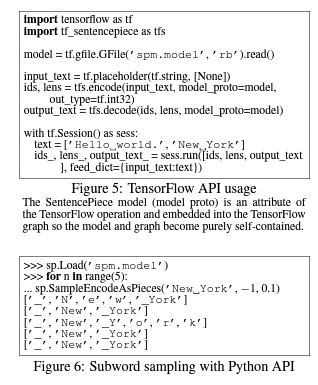

## 5 Conclusions

본 논문에서는 neural-based text preprocessing를 위해 설계된 오픈 소스 subword tokenizer 및 detokenizer인 SentencePiece를 소개하였습니다. SentencePiece는 subword tokenization을 수행할 뿐만 아니라 텍스트를 직접 id 시퀀스로 변환하여 언어별 리소스에 의존하지 않고 순수한 end-to-end 시스템을 개발하는 데 도움을 줍니다. SentencePiece의 모델 파일은 정규화 및 subword segmentation의 완벽한 reproducibility를 보장하기 위해 독립적으로 설계되었습니다. 

SentencePiece가 안정적이고 reproducible한 text preprocessing 도구를 제공하고 연구 커뮤니티가 언어에 구애받지 않는 다국어 아키텍처로 나아가는데 도움이 되기를 바랍니다.